In [2]:
"""Preprocessing Neural Spike Data."""

'Preprocessing Neural Spike Data.'

In [33]:
import importlib
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import os

import numpy as np

import nrtk.io
import nrtk.vis
import nrtk.sort
importlib.reload(nrtk.io)
importlib.reload(nrtk.vis)
importlib.reload(nrtk.sort)

import warnings
warnings.filterwarnings("ignore")

OUTPUT_DIR = '/scratch/users/nmiolane/sommet/output'
HOME_DIR = '/home/nina/code/sommet'
DATA_DIR = os.path.join('/neuro/recordings', '2018-05-31_15-43-39')
# TODO(nina): Look at this https://github.com/vandermeerlab/nept/blob/master/nept/loaders_neuralynx.py

np.random.seed(seed=1990)

# Load Signals

In [2]:
signals_path = os.path.join(OUTPUT_DIR, 'load_signals.npy')
signals = np.load(signals_path)

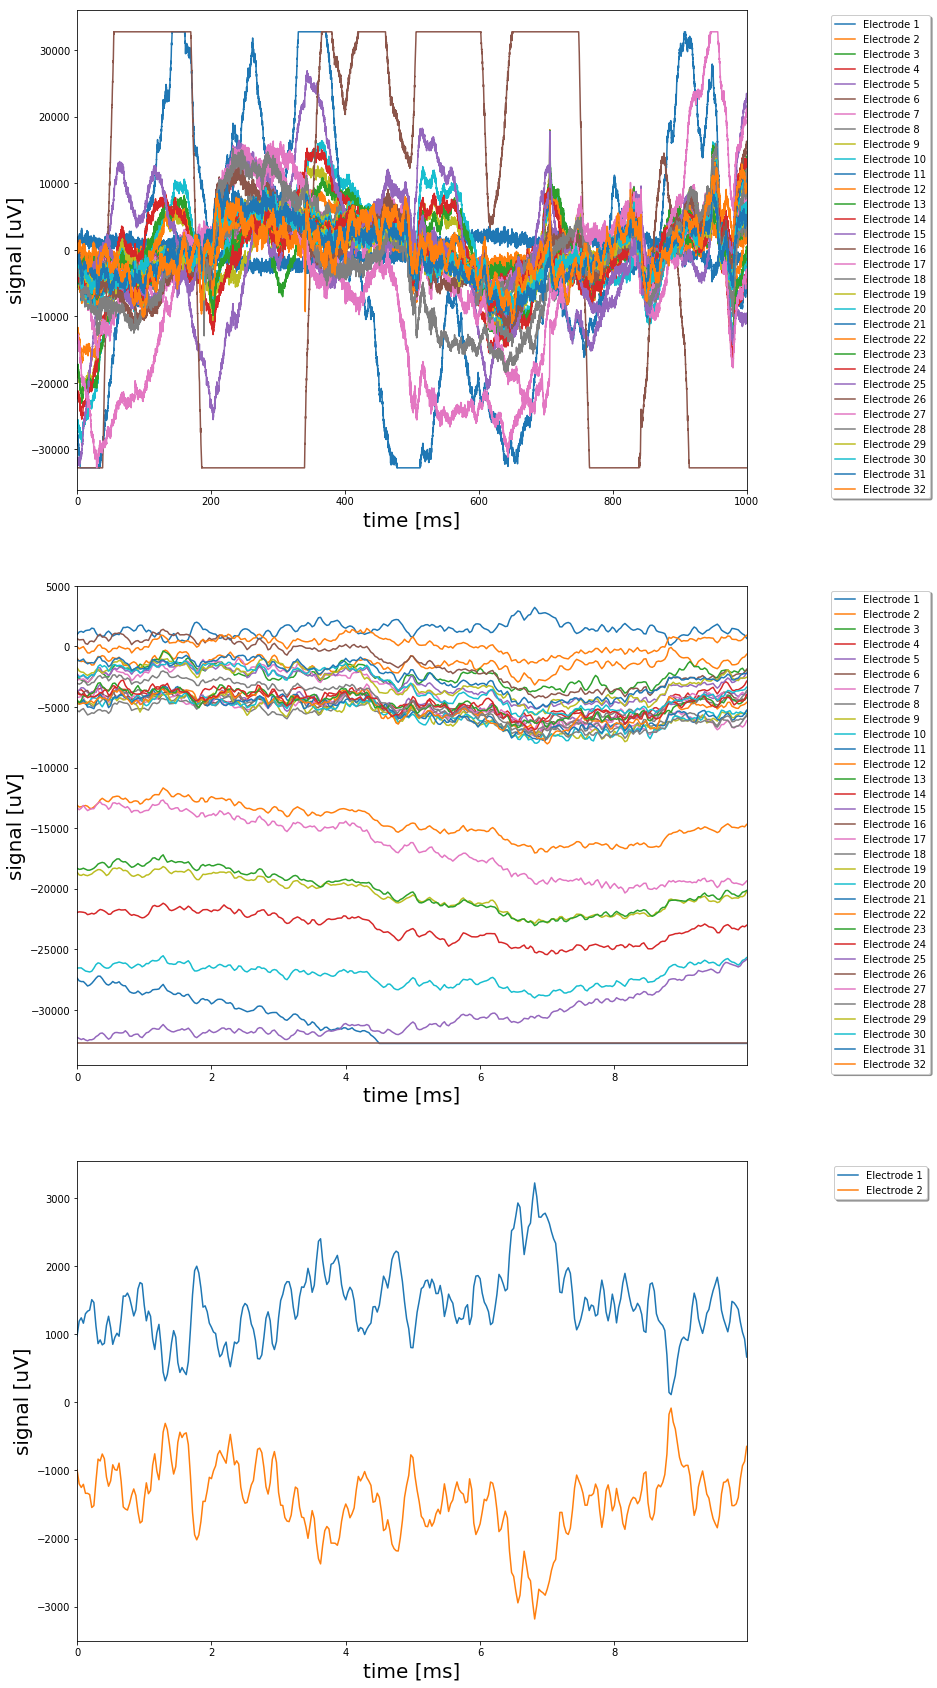

In [8]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(20, 30))

ax = axes[0]
ax = nrtk.vis.plot_signal_electrodes(ax, signals)

ax = axes[1]
ax = nrtk.vis.plot_signal_electrodes(ax, signals, t_min=0., t_max=0.01)

ax = axes[2]
ax = nrtk.vis.plot_signal_electrodes(ax, signals, t_min=0., t_max=0.01, electrodes_ids=[0, 1])

# Filter Signals

In [9]:
signals_path = os.path.join(OUTPUT_DIR, 'filter_signals.npy')
signals = np.load(signals_path)

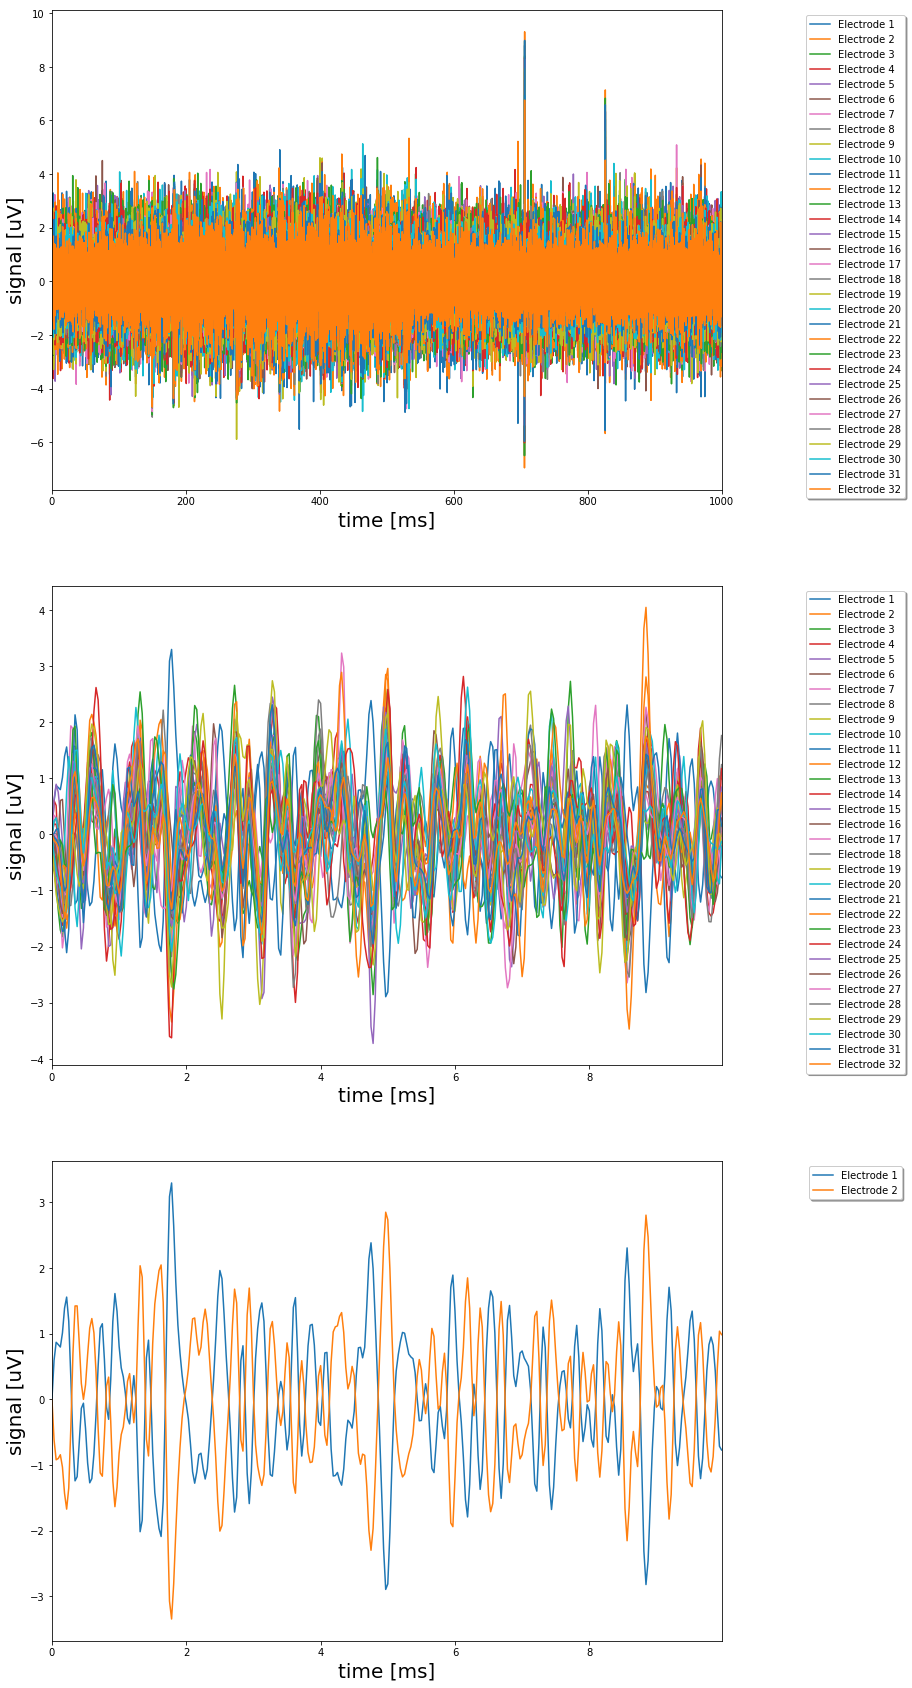

In [10]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(20, 30))

ax = axes[0]
ax = nrtk.vis.plot_signal_electrodes(ax, signals)

ax = axes[1]
ax = nrtk.vis.plot_signal_electrodes(ax, signals, t_min=0., t_max=0.01)

ax = axes[2]
ax = nrtk.vis.plot_signal_electrodes(ax, signals, t_min=0., t_max=0.01, electrodes_ids=[0, 1])

## Waterfall view

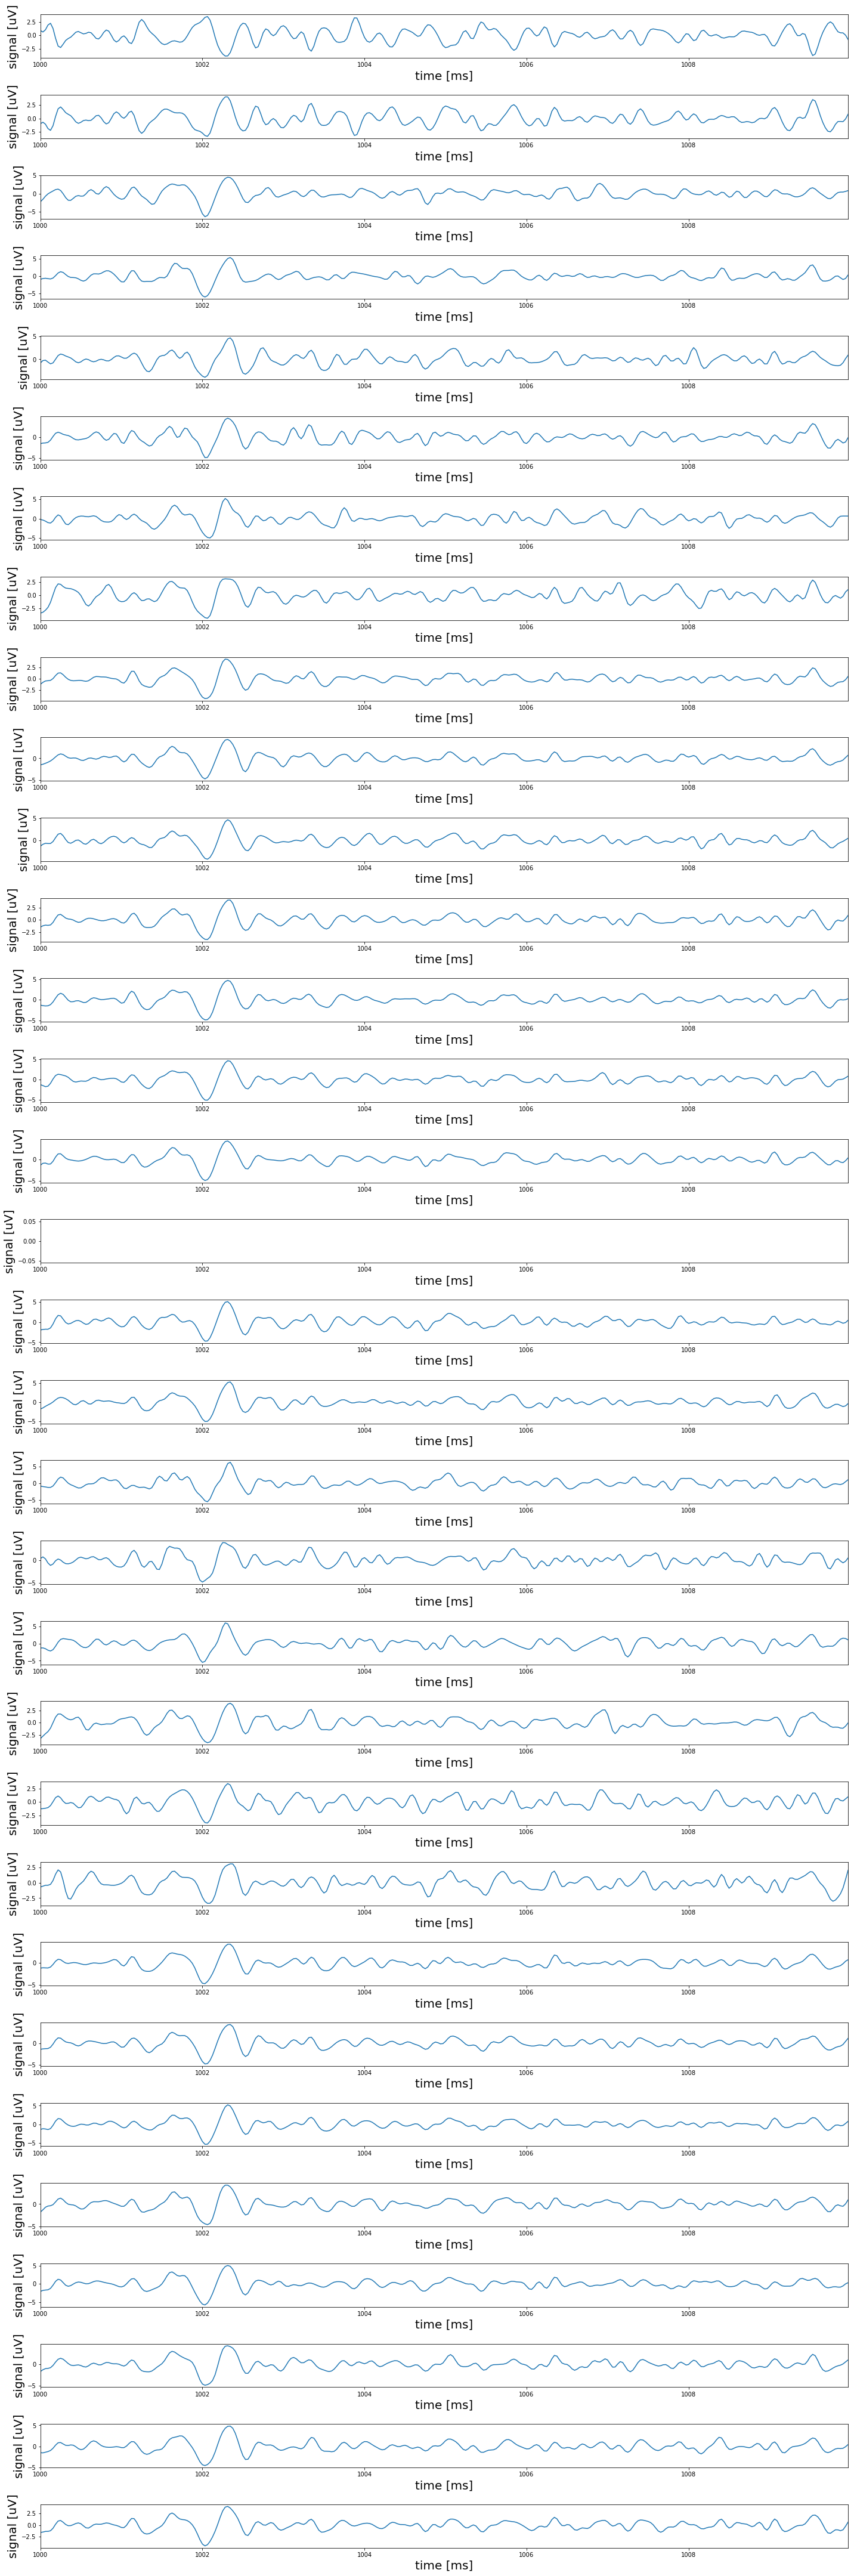

In [28]:
n_electrodes, _ = signals.shape

fig, axes = plt.subplots(nrows=n_electrodes, ncols=1, figsize=(20, 60))
for i in range(n_electrodes):
    ax = axes[i]
    nrtk.vis.plot_signal(ax, signals[i], label='Electrode %d' % (i+1), t_min=1., t_max=1.01)
plt.tight_layout()

## Correlations

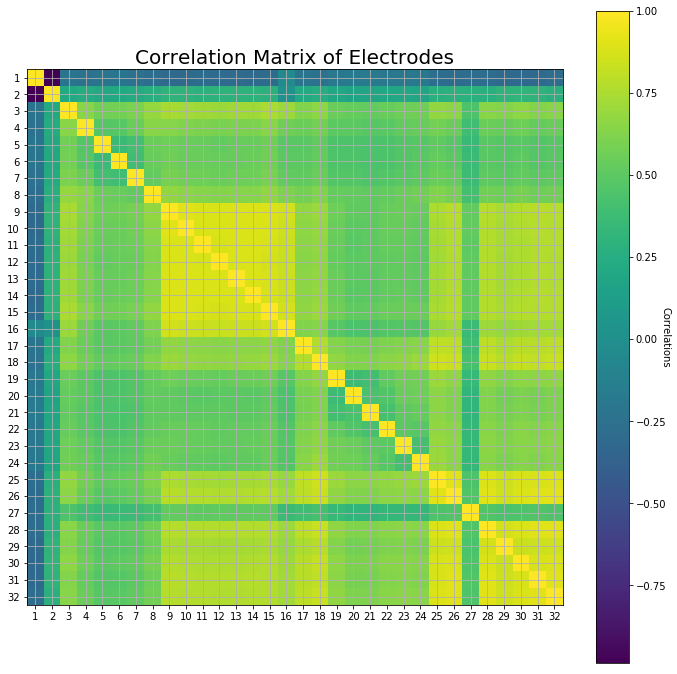

In [10]:
fig, ax = plt.subplots(figsize=(12, 12))
ax = nrtk.vis.plot_correlation(fig, ax, signals)

# Extract Spikes

## Explore peaks (re-running)

In [17]:
peaks_ids = nrtk.sort.extract_peaks_ids(signals)

Electrode 1. Found 19084 peaks over 26041856 recorded data.
Electrode 2. Found 18789 peaks over 26041856 recorded data.
Electrode 3. Found 15916 peaks over 26041856 recorded data.
Electrode 4. Found 18071 peaks over 26041856 recorded data.
Electrode 5. Found 26474 peaks over 26041856 recorded data.
Electrode 6. Found 24154 peaks over 26041856 recorded data.
Electrode 7. Found 19430 peaks over 26041856 recorded data.
Electrode 8. Found 13253 peaks over 26041856 recorded data.
Electrode 9. Found 9392 peaks over 26041856 recorded data.
Electrode 10. Found 9660 peaks over 26041856 recorded data.
Electrode 11. Found 9625 peaks over 26041856 recorded data.
Electrode 12. Found 10529 peaks over 26041856 recorded data.
Electrode 13. Found 10017 peaks over 26041856 recorded data.
Electrode 14. Found 10446 peaks over 26041856 recorded data.
Electrode 15. Found 9101 peaks over 26041856 recorded data.
Electrode 16. Found 2158 peaks over 26041856 recorded data.
Electrode 17. Found 33626 peaks over 2

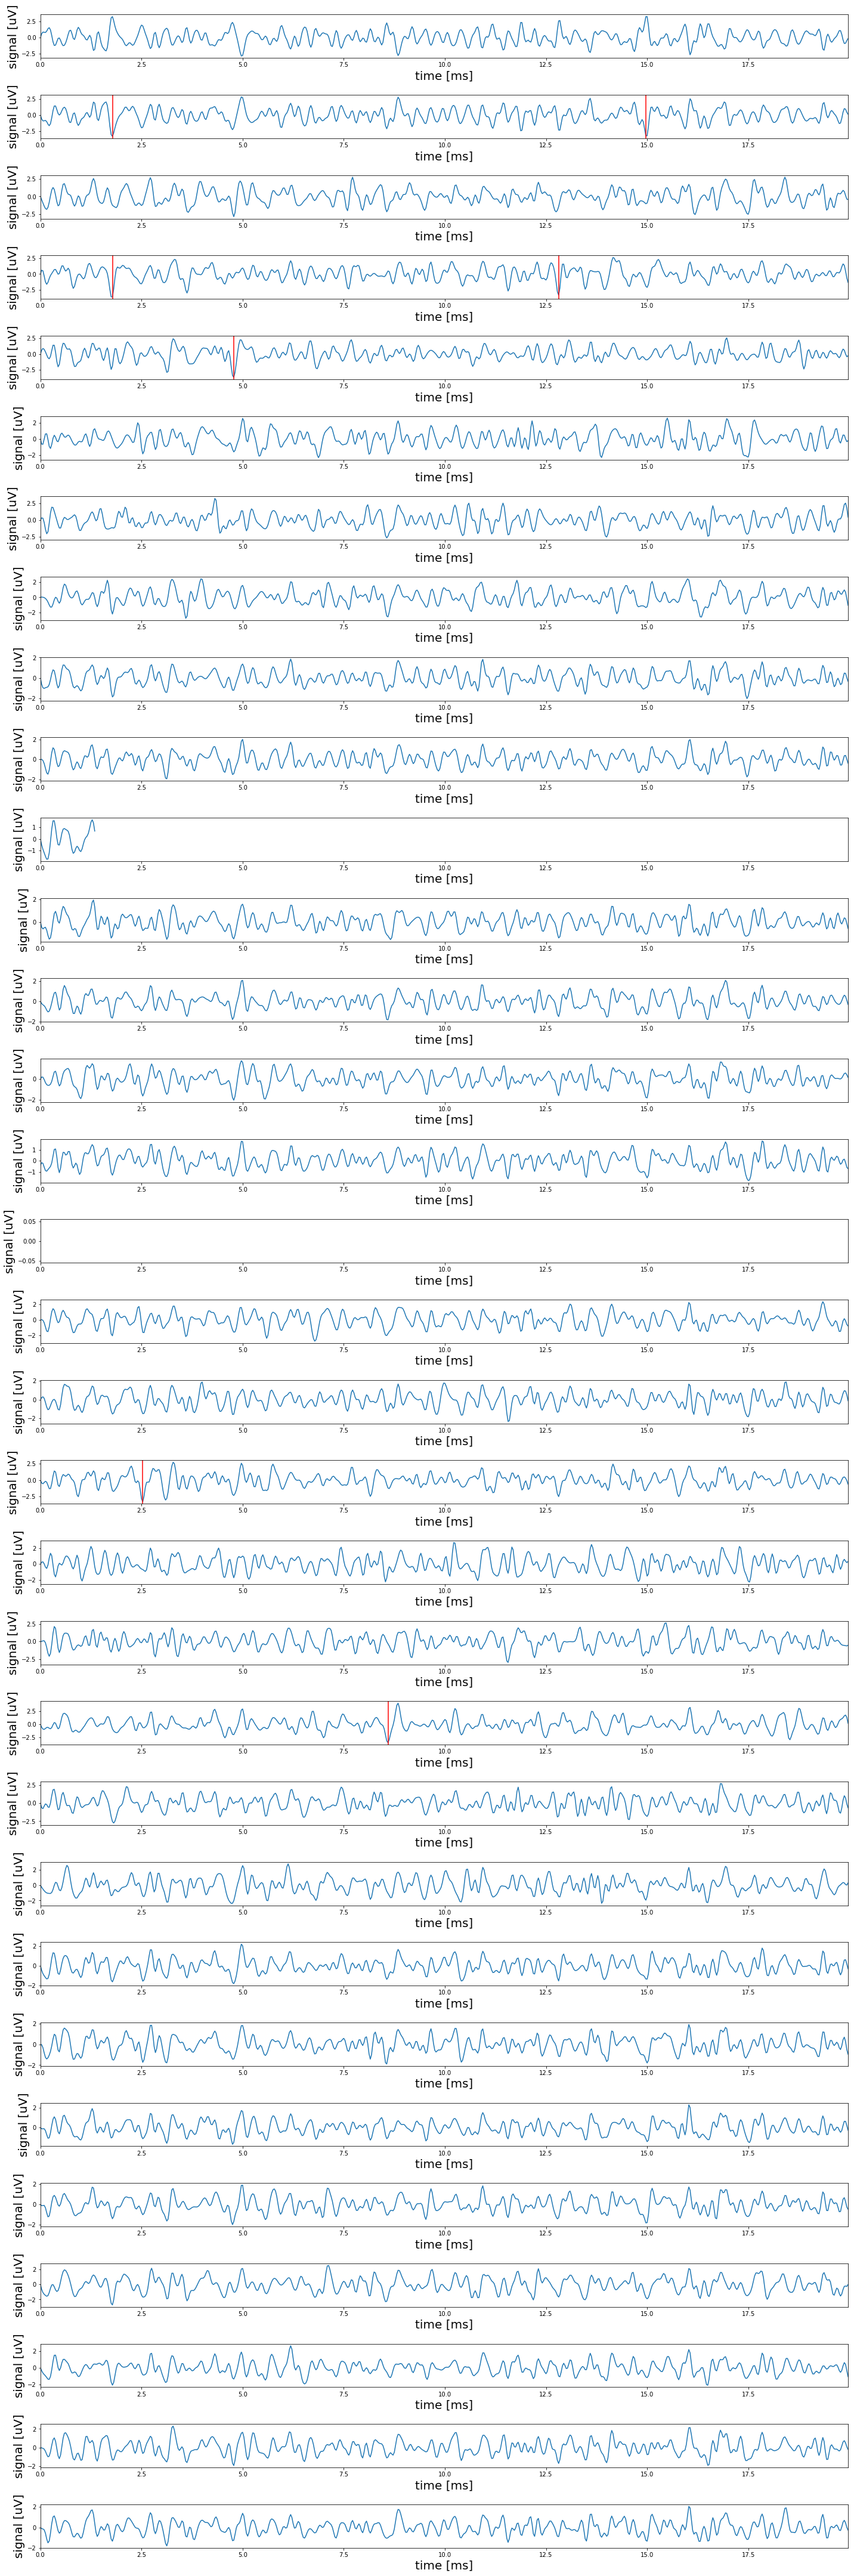

In [19]:
n_electrodes, _ = signals.shape
time = nrtk.vis.get_time(signals)

fig, axes = plt.subplots(nrows=n_electrodes, ncols=1, figsize=(20, 60))
for electrode_id in range(n_electrodes):
    ax = axes[electrode_id]
    nrtk.vis.plot_signal(ax, signals[electrode_id], label='Electrode %d' % (electrode_id+1), t_min=0., t_max=0.02)
    peak_0_msecs = 1000 * time[peaks_ids[electrode_id][0]]
    peak_1_msecs = 1000 * time[peaks_ids[electrode_id][1]]
    ax.axvline(x=peak_0_msecs, color='red')
    ax.axvline(x=peak_1_msecs, color='red')
plt.tight_layout()

## PCA and KMeans for Spike Sorting

In [28]:
pca_kmeans_path = os.path.join(OUTPUT_DIR, 'extract_spikes.npy')
pca_kmeans = np.load(pca_kmeans_path).item()

In [38]:
importlib.reload(nrtk.io)
importlib.reload(nrtk.vis)
importlib.reload(nrtk.sort)

<module 'nrtk.sort' from '/home/nina/code/sommet/nrtk/sort.py'>

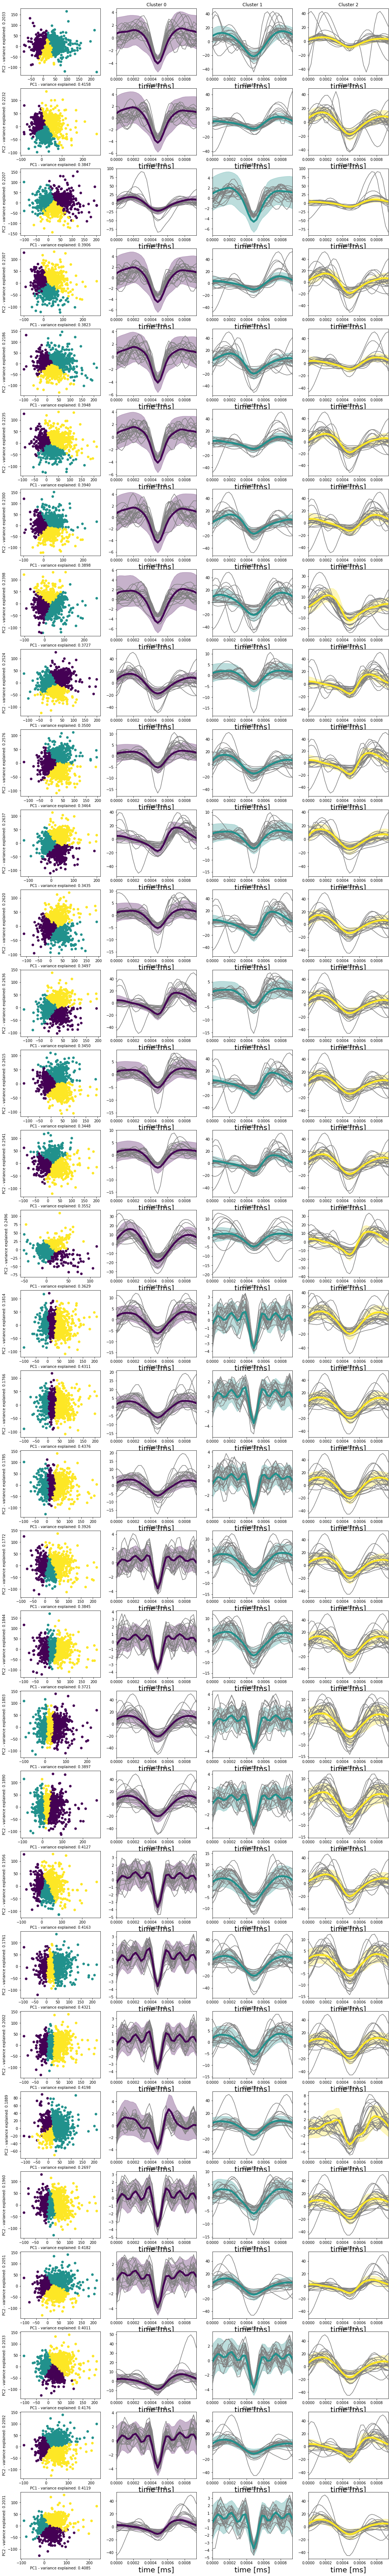

In [44]:
importlib.reload(nrtk.io)
importlib.reload(nrtk.vis)
importlib.reload(nrtk.sort)

n_electrodes, _ = signals.shape

fig, axes = plt.subplots(nrows=32, ncols=4, figsize=(18, 4 * n_electrodes))
for electrode_id in range(n_electrodes):
    pca_kmeans_electrode = pca_kmeans[electrode_id]
    n_clusters = len(pca_kmeans_electrode['centers'])
    
    ax = axes[electrode_id, 0]
    ax = nrtk.vis.plot_pca_kmeans(ax, pca_kmeans_electrode)

    for cluster_id in range(n_clusters):
        ax = axes[electrode_id, cluster_id+1]
        ax = nrtk.vis.plot_centers(ax, pca_kmeans_electrode, center_id=cluster_id)

# 2. Load and Plot NVT files: Video Tracking

In [53]:
def load_nvt(data_file, remove_empty=False):
    """
    Read Neuralynx NVT data.
    https://neuralynx.com/software/NeuralynxDataFileFormats.pdf
    """
    # QUESTION: Why is there less time steps than raw data? len(nvt_raw['TimeStamp']) != len(nvt_raw['extracted_x']) 
    with open(data_file, 'rb') as fid:
        fid.seek(HEADER_SIZE)
        
        data_format = np.dtype([
            ('stx', np.uint16),
            ('id', np.uint16),
            ('data_size', np.uint16),
            ('TimeStamp', np.uint64), # in um
            ('Points', np.uint32, 400),
            ('nrc', np.int16),  # Unused
            ('extracted_x', np.int32),
            ('extracted_y', np.int32),
            ('extracted_angle', np.int32),
            ('targets', np.int32, 50)])
        raw = np.fromfile(fid, dtype=data_format)
    
    selected_raw = dict()
    selected_raw['TimeStamp'] = raw['TimeStamp']
    selected_raw['extracted_x'] = np.array(raw['extracted_x'], dtype=float)
    selected_raw['extracted_y'] = np.array(raw['extracted_y'], dtype=float)
    selected_raw['targets'] = np.array(raw['targets'], dtype=float)
        
    if remove_empty:
        empty_idx = (raw['extracted_x'] == 0) & (raw['extracted_y'] == 0)
        for key in selected_raw:
            selected_raw[key] = selected_raw[key][~empty_idx]

    return nvt_raw

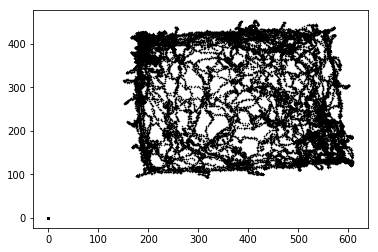

In [54]:
# QUESTION: Why doesn't it look like a labyrinth?
plt.plot(nvt_raw['extracted_x'], nvt_raw['extracted_y'], 'k.', ms=1)
plt.show()

In [55]:
# TODO(nina): These are placeholders, replace them with real values
pxl_to_cm_x = 1
pxl_to_cm_y = 1
x_cm = nvt_raw['extracted_x'] / pxl_to_cm_x
y_cm = nvt_raw['extracted_y'] / pxl_to_cm_y
xy = np.hstack([x_cm, y_cm])
time = nvt_raw['TimeStamp']

In [237]:
#electrode_id = 0
#filename = 'CSC{}.ncs'.format(electrode_id+1)
#filepath = os.path.join(data_dir, filename)
#print('Loading %s...' % filepath)
#raw_ncs = load_ncs(filepath)

nvt_file = os.path.join(DATA_DIR, 'VT1.nvt')
print(nvt_file)
nvt_raw = nrtk.io.load_nvt(nvt_file)
print(nvt_raw)

timestamps_ncs = raw_ncs['TimeStamp']
timestamps_nvt = raw_nvt['TimeStamp']
intersection = np.intersect1d(timestamps_ncs, time_stamps_nvt)

/neuro/recordings/2018-05-31_15-43-39/VT1.nvt
{'TimeStamp': array([104904529770, 104904545706, 104904561643, ..., 105717859262,
       105717875710, 105717891950], dtype=uint64), 'extracted_x': array([362., 362., 362., ..., 435., 432., 432.]), 'extracted_y': array([398., 399., 398., ..., 348., 346., 344.]), 'targets': array([[1.09995659e+09, 5.62823530e+08, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.10002212e+09, 5.62889066e+08, 2.60509210e+07, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.09995659e+09, 5.62823530e+08, 2.62475250e+07, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [1.09648325e+09, 2.29052670e+07, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.09628664e+09, 2.25775850e+07, 5.59677870e+08, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.09635218e+09, 2.26431230e+07, 5.59350189e+08, ...,
        0.0000000

NameError: name 'raw_ncs' is not defined

In [ ]:
# TODO(nina): Spike sorting = isolate neurons by clustering.
# --> Needed to isolate place neurones and hope to decode position